# Regression & Bayesian Analysis with Food Deserts

## Abstract: 

### Motivation:
The insurance industry has played a major role in shaping the United State's healthcare system. Reimbursements, until recent years, were based on the acuity care, which promoted a sytem that focused primarily an acute illnesses that neccesitated hospitalization. This led to a "sickcare" system, that addressed complications of chronic disease, rather than promoting wellness and prevention. 

In an effort to address high healthcare associated costs, the healthcare enterprise is shifting their focus to prevention. Obesity, a major contributing factor of preventable chronic disease, has become one of the primary targets of recent healthcare reforms. That said, many efforts have been made to address areas of low food access, and the detrimental health effects caused by "Food Deserts". 

### Goals & Analysis Questions:
1. Explore factors that relate to "Food Deserts" in California:
 - Determine the demographics and locations of "Food Desert" counties.
 - Determine the demographics and locations of "Non-Food Desert" counties.

2. Assess the relationship between "Food Deserts" and community health status:
 - Do "Food Desert" counties have a higher prevelance of chronic disease?
 - Are "Food Desert" county residents less physically active?
 - Do "Food Desert" counties have a higher prevelance of preventable illnesses?

 
3. Determine whether "Food Desert" counties are also "Healthcare Deserts":
 - Do "Food Desert" counties have less access to healthcare services?
 - Do "Food Desert" counties have higher hospital readmission/mortality rates?
 - Do "Food Desert" counties have a higher rates of Opiod Rx's?


### Hypotheses:
1. Social factors such as lower education achievement, and employment rates are correlated with the number of food deserts within a county. Demographic factors such as age, and ethnic diversity are correlated with the number of food deserts present within a county.

2. "Food Desert" counties have poorer community health:
    * "Food Desert" counties have higher rates of chronic disease.
    * "Food Desert" counties have higher rates of preventable illnesess.
    * "Food Desert" counties have lower rates of physical activity.
    * "Food Desert" counties have higher rates of Opiod Rx's.
   
3. "Food Desert" counties are also "Healthcare Deserts":
    * "Food Desert" counties have less access to outpatient healthcare services.
    * "Food Desert" counties have fewer hospitals.
    * "Food Desert" counties have higher hospital readmission/mortality rates. 


### Conclusions:

... TBD ... 

#### "Food Desert" counties have poorer community health:
A positive correlation exists between the number county food deserts and the following explanatory variables:
- county level diabetes rates (age-adjusted)
- county level inactive rates (age-adjusted)
- county level sexual transmitted disease totals

However no correlation was seen between the number of county food deserts and the following explanatory variables: 
- county level obesity rates (age-adjusted)
- county level incidence of illnesses for which vaccinations exist
- opiod prescriptions per 100000 residents

3. "Food Desert" counties are also "Healthcare Deserts":


In [48]:
from scipy.stats.stats import pearsonr
import numpy as np
np.set_printoptions(precision=4, suppress=True)

import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from IPython.core.pylabtools import figsize
import scipy.stats as stats

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
df = pd.read_csv('/Users/desert/desert_workspace/desert_data/fd_data.csv')
df = df.drop(['Unnamed: 0','State'], axis=1)
df=df.fillna(0)
df.rename(columns={'Influenza Death (<65 years of age)':'senior_flu_deaths'}, inplace=True)
df.rename(columns={'Varicella Hospitalizations':'varicella_hospitalizations'}, inplace=True)
df.head()

,County,POP2010,food_deserts,n_tracts,urban_des,rural_des,n_urban,n_rural,des_percent,perc_effected,...,varicella_hospitalizations,Salmonellosis,opiods_rx_1000,opiods_greater_than_stateavg,MILK_PRICE10,SODA_PRICE10,MILK_SODA_PRICE10,PCH_FFR_07_12,FFR07,FFR12
0,Alameda,1510271,15,360,15.0,0.0,354,6,0.041667,0.018032,...,0.132,16.978,557.20,0,1.122215,1.164422,0.891575,8.902878,1112.0,1211
1,Alpine,1175,0,1,0.0,0.0,0,1,0.000000,0.266288,...,0.000,0.000,578.68,0,1.032918,1.089488,0.877073,-50.000000,2.0,1
2,Amador,38091,0,9,0.0,0.0,0,9,0.000000,0.149514,...,0.000,7.923,1244.76,1,1.032918,1.089488,0.877073,-5.555556,18.0,17
3,Butte,220000,14,51,13.0,1.0,38,13,0.274510,0.145583,...,0.455,25.913,1389.20,1,0.996443,1.130546,0.815374,2.684564,149.0,153
4,Calaveras,45578,0,10,0.0,0.0,2,8,0.000000,0.203345,...,0.000,8.800,1068.98,1,1.032918,1.089488,0.877073,-7.407407,27.0,25


In [93]:
#print df.columns.tolist()

def relative_population_scaler(x_feature):
    county_pop = df['POP2010']
    state_pop = df['POP2010'].sum()
    normalized_x_feature = (county_pop / state_pop) * df[x_feature]
    return normalized_x_feature

df['quant'] = np.nan

for q in [0.75, 0.5, 0.25]:
    df.loc[(df.POP2010 <= df.POP2010.quantile(q + 0.25)) & (df.POP2010 > df.POP2010.quantile(q)), 'quant'] = q

df.quant.fillna(0.0, inplace=True)


In [94]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
df['POP2010'] = mms.fit_transform(df['POP2010'])

/Users/desert/anaconda/envs/linreg/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [95]:
ex = ['urban_des', 'rural_des', 'cnty_obesity_pct','LowIncomeTracts', 'pop_effected','cnty_dm_pct','cnty_inactive_pct','Adolescent_births', 'MILK_SODA_PRICE10', 'FFR12']

targets = ['food_deserts','pop_effected','des_percent']
    
base = ['County','n_tracts', 'n_urban','n_rural', 'LowIncomeTracts', 'POP2010']
#base = ['County','n_tracts', 'n_urban', 'POP2010']

demo = [ 'PCT_HSPNC','PCT_WHITE','PCT_BLACK', 'PCT_ASIAN', 'PCT_AMIND_ESK', 'PCT_ISLANDER', 'PCT_MULTI', 'PCT_OTHER', 'PCT_65OVER', 'PCT_18_64', 'PCT_UNDR18', 'PCT_UNDER5']
age = ['PCT_65OVER', 'PCT_18_64', 'PCT_UNDR18', 'PCT_UNDER5']
race = [ 'PCT_HSPNC','PCT_WHITE','PCT_BLACK', 'PCT_ASIAN', 'PCT_AMIND_ESK', 'PCT_ISLANDER', 'PCT_MULTI', 'PCT_OTHER']

community_health = [ 'p_hs_edatt','unemployment_rate','opiods_rx_1000','cnty_obesity_pct_adj','ABR','FFR07','cnty_dm_pct_adj','cnty_inactive_pct_adj']

vaccine = ['Tuberculosis', 'senior_flu_deaths', 'Measles', 'Mumps', 'Pertussis', 'Rubella', 'varicella_hospitalizations']

std = ['Chlamydia','Gonorrhea','HIV']

social = ['p_hs_edatt','low_vehicle_tracts','total_housing_units','pop_in_group_housing','unemployment_rate','MILK_PRICE10','SODA_PRICE10','MILK_SODA_PRICE10','PCH_FFR_07_12','FFR07','FFR12']

access = ['PC_PHYS_R','DENTIST_R','PSYCH_R', 'n_hospitals']

hosp_mort = [ 'mort_30_ami','mort_30_cabg','mort_30_copd','mort_30_hf','mort_30_pn', 'mort_30_stk']
hosp_readmits = ['readm_30_ami', 'readm_30_cabg', 'readm_30_copd','readm_30_hf','readm_30_hip_knee','readm_30_hosp_wide','readm_30_pn','readm_30_stk']


"Food Desert" counties have poorer community health:  
* "Food Desert" counties have higher rates of chronic disease.
* "Food Desert" counties have higher rates of preventable illnesess.
* "Food Desert" counties have lower rates of physical activity.

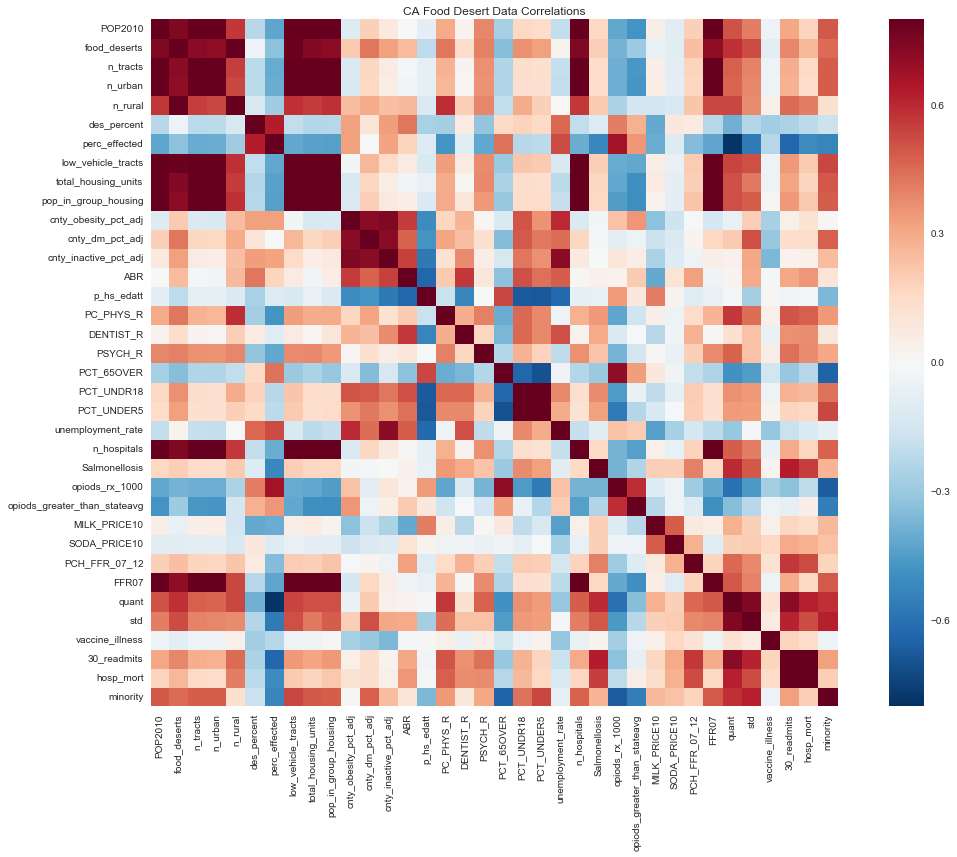

In [96]:
df['std']=df[std].sum(axis=1)
df['vaccine_illness'] = df[vaccine].sum(axis=1)
df['30_readmits'] = df[hosp_readmits].sum(axis=1) 
df['hosp_mort'] = df[hosp_mort].sum(axis=1) / 100

def nonwhite(x):
    return 100 - x

df['minority'] = df['PCT_WHITE'].apply(nonwhite)

df=df.drop(race+hosp_mort+hosp_readmits+ex+std+vaccine+race+['PCT_18_64'],axis=1)

corrmat = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn, and add a title to the plot
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()

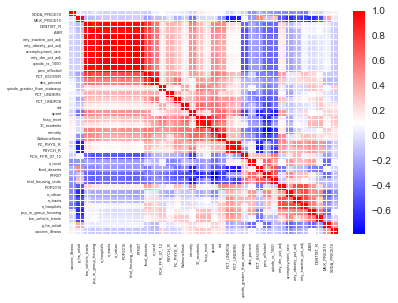

In [97]:
# corrmat = df.corr()

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(16, 12))

# # Draw the heatmap using seaborn, and add a title to the plot
# sns.heatmap(corrmat, vmax=.8, square=True)
# ax.set_title('CA Food Desert Data Correlations')
# f.tight_layout()
# calculate the correlation matrix
corr_dataframe = df.corr()

# compute hierarchical cluster on both rows and columns for correlation matrix and plot heatmap 
def corr_heatmap(corr_dataframe):
    import scipy.cluster.hierarchy as sch
    
    corr_matrix = np.array(corr_dataframe)
    col_names = corr_dataframe.columns
    
    Y = sch.linkage(corr_matrix, 'single', 'correlation')
    Z = sch.dendrogram(Y, color_threshold=0, no_plot=True)['leaves']
    corr_matrix = corr_matrix[Z, :]
    corr_matrix = corr_matrix[:, Z]
    col_names = col_names[Z]
    im = plt.imshow(corr_matrix, interpolation='nearest', aspect='auto', cmap='bwr')
    plt.colorbar()
    plt.xticks(range(corr_matrix.shape[0]), col_names, rotation='vertical', fontsize=4)
    plt.yticks(range(corr_matrix.shape[0]), col_names[::-1], fontsize=4)
    
# plot
corr_heatmap(corr_dataframe)

Removed predictors (in order): 

n_urban
total_housing_units
FFR07
n_tracts
n_hospitals
low_vehicle_tracts
pop_in_group_housing
PCT_UNDER5
hosp_mort


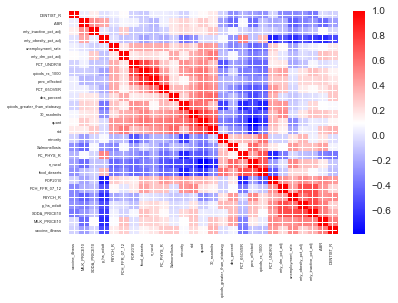

In [98]:
def remove_high_corr(corr_dataframe, thresh = 0.9):
    '''remove predictors with high pairwise correlation'''
    abs_corr = np.abs(corr_dataframe).as_matrix() # absolute correlation matrix
    col_names = list(corr_dataframe.columns)
    
    # set up diagonal to 0
    np.fill_diagonal(abs_corr, 0)
    
    print "Removed predictors (in order): \n"
    while np.max(abs_corr) >= thresh:
        i, j = np.unravel_index(abs_corr.argmax(), abs_corr.shape) # find maximum element
        # print abs_corr[i, j]
        rdx = which_to_remove(i, j, abs_corr)
        # remove corresponding predictor
        print col_names.pop(rdx)
        abs_corr = np.delete(abs_corr, rdx, 0)
        abs_corr = np.delete(abs_corr, rdx, 1)
        
    return col_names

def which_to_remove(i, j, abs_corr):
    '''compare two predictors and remove the one with higher abs correlation with other predictors'''
    i_absmean = np.mean(abs_corr[i, np.where(abs_corr[i,:] == 0)])
    j_absmean = np.mean(abs_corr[j, np.where(abs_corr[j,:] == 0)])
    
    return i if i_absmean > j_absmean else j

# remained predictors
col_remained = remove_high_corr(corr_dataframe)
data=df[col_remained]
corr_dataframe = data.corr()

corr_heatmap(corr_dataframe)

In [99]:
def covariance(variable_1, variable_2, bias=0):
    observations = float(len(variable_1))
    return np.sum((variable_1 - np.mean(variable_1)) * (variable_2 - np.mean(variable_2)))/(observations-min(bias,1))

def standardize(variable):
    return (variable - np.mean(variable)) / np.std(variable)

def correlation(var1,var2,bias=0):
    return covariance(standardize(var1), standardize(var2),bias)

print ('Correlation from Scipy pearsonr estimation: %0.5f' % pearsonr(df['unemployment_rate'], df['food_deserts'])[0])

Correlation from Scipy pearsonr estimation: 0.02549


In [100]:
linear_regression = smf.ols(formula='food_deserts ~ cnty_dm_pct_adj+n_rural+n_tracts', data=df)
fitted_model = linear_regression.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           food_deserts   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     80.27
Date:                Sun, 07 Aug 2016   Prob (F-statistic):           6.74e-20
Time:                        01:51:42   Log-Likelihood:                -185.49
No. Observations:                  58   AIC:                             379.0
Df Residuals:                      54   BIC:                             387.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept         -23.0486      6.228     -3.701      0.001       -35.535   -10.563
cnty_dm_pct_adj     2.8524      0.868      3.287      0.002         1.113     4.592
n_rural             0.7798      0.102      7.644      0.000         0.575     0.984
n_tracts            0.0164      0.003      5.481      0.000         0.010     0.022
==============================================================================
Omnibus:                       35.076   Durbin-Watson:                   2.390
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.183
Skew:                           1.513   Prob(JB):                     1.81e-32
Kurtosis:                      10.164   Cond. No.                     2.75e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [101]:
print (fitted_model.params)
betas = np.array(fitted_model.params)
fitted_values = fitted_model.predict()

Intercept         -23.048570
cnty_dm_pct_adj     2.852415
n_rural             0.779771
n_tracts            0.016394
dtype: float64


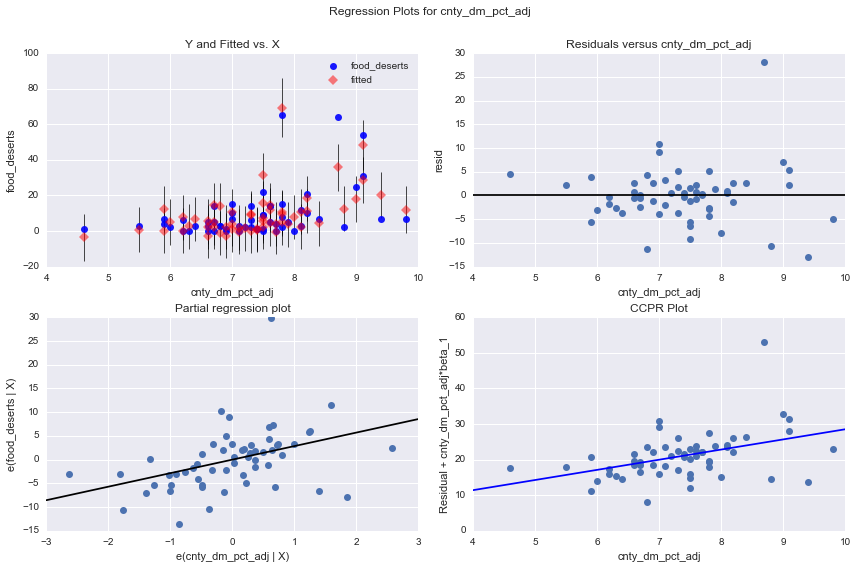

In [102]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(fitted_model, "cnty_dm_pct_adj", fig=fig)

In [103]:
mean_sum_squared_errors = np.sum((df['food_deserts']-df['food_deserts'].mean())**2)
regr_sum_squared_errors = np.sum((df['food_deserts']-fitted_values)**2)
(mean_sum_squared_errors-regr_sum_squared_errors) / mean_sum_squared_errors

0.8168373722857392

In [104]:
linear_regression = smf.ols(formula='food_deserts ~ cnty_obesity_pct_adj+n_rural+n_tracts', data=df)
fitted_model = linear_regression.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           food_deserts   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     68.90
Date:                Sun, 07 Aug 2016   Prob (F-statistic):           1.84e-18
Time:                        01:52:32   Log-Likelihood:                -189.06
No. Observations:                  58   AIC:                             386.1
Df Residuals:                      54   BIC:                             394.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept              -13.8622      6.121     -2.265      0.028       -26.134    -1.590
cnty_obesity_pct_adj     0.4796      0.264      1.818      0.075        -0.049     1.008
n_rural                  0.7840      0.114      6.907      0.000         0.556     1.012
n_tracts                 0.0184      0.003      5.497      0.000         0.012     0.025
==============================================================================
Omnibus:                       36.141   Durbin-Watson:                   2.283
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.223
Skew:                           1.676   Prob(JB):                     3.90e-28
Kurtosis:                       9.403   Cond. No.                     2.52e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [105]:
linear_regression = smf.ols(formula='food_deserts ~ cnty_inactive_pct_adj+n_rural+n_tracts', data=df)
fitted_model = linear_regression.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           food_deserts   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     74.96
Date:                Sun, 07 Aug 2016   Prob (F-statistic):           3.00e-19
Time:                        01:52:47   Log-Likelihood:                -187.11
No. Observations:                  58   AIC:                             382.2
Df Residuals:                      54   BIC:                             390.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept               -16.6304      5.208     -3.193      0.002       -27.073    -6.188
cnty_inactive_pct_adj     0.8349      0.309      2.702      0.009         0.215     1.454
n_rural                   0.7907      0.105      7.528      0.000         0.580     1.001
n_tracts                  0.0172      0.003      5.581      0.000         0.011     0.023
==============================================================================
Omnibus:                       37.009   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.881
Skew:                           1.721   Prob(JB):                     3.80e-29
Kurtosis:                       9.505   Cond. No.                     2.22e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

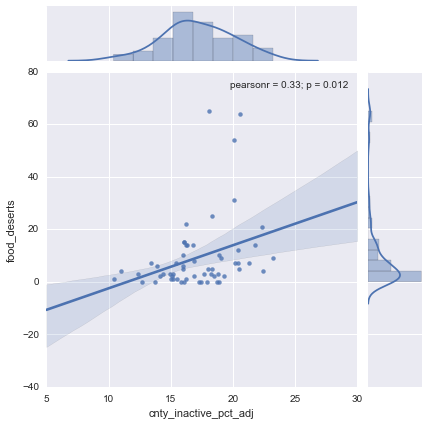

In [106]:
# fig = plt.figure(figsize=(12,8))
# fig = sm.graphics.plot_regress_exog(fitted_model, "cnty_inactive_pct_adj", fig=fig)
sns.jointplot(x='cnty_inactive_pct_adj', y='food_deserts',data=df,kind='reg')

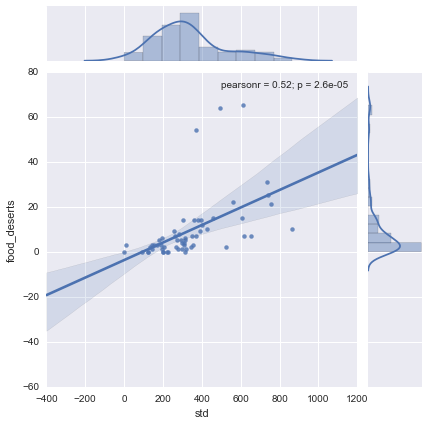

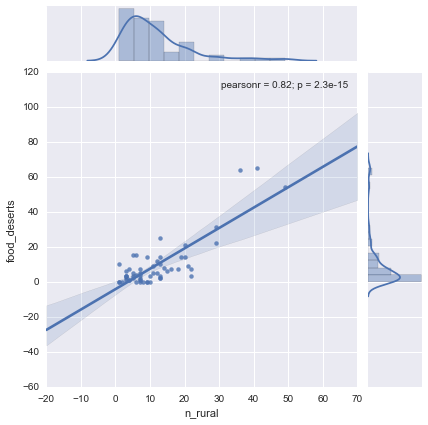

In [107]:
sns.jointplot(x='std', y='food_deserts',data=df,kind='reg')
sns.jointplot(x='n_rural', y='food_deserts',data=df,kind='reg')

In [108]:
linear_regression = smf.ols(formula='food_deserts ~ std+n_rural+n_tracts', data=df)
fitted_model = linear_regression.fit()
fitted_model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           food_deserts   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     73.86
Date:                Sun, 07 Aug 2016   Prob (F-statistic):           4.13e-19
Time:                        01:53:17   Log-Likelihood:                -187.45
No. Observations:                  58   AIC:                             382.9
Df Residuals:                      54   BIC:                             391.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -6.3528      1.851     -3.433      0.001       -10.063    -2.643
std            0.0128      0.005      2.565      0.013         0.003     0.023
n_rural        0.8055      0.105      7.698      0.000         0.596     1.015
n_tracts       0.0145      0.003      4.555      0.000         0.008     0.021
==============================================================================
Omnibus:                       37.877   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.442
Skew:                           1.645   Prob(JB):                     4.37e-37
Kurtosis:                      10.646   Cond. No.                     1.01e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [109]:
linear_regression = smf.ols(formula='food_deserts ~ opiods_rx_1000+n_tracts', data=df)
fitted_model = linear_regression.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           food_deserts   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     31.44
Date:                Sun, 07 Aug 2016   Prob (F-statistic):           7.85e-10
Time:                        01:53:32   Log-Likelihood:                -212.61
No. Observations:                  58   AIC:                             431.2
Df Residuals:                      55   BIC:                             437.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          9.2741      4.106      2.259      0.028         1.046    17.502
opiods_rx_1000    -0.0044      0.004     -1.111      0.271        -0.012     0.004
n_tracts           0.0291      0.004      6.793      0.000         0.020     0.038
==============================================================================
Omnibus:                       60.033   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              363.843
Skew:                           2.881   Prob(JB):                     9.83e-80
Kurtosis:                      13.833   Cond. No.                     3.16e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [110]:
linear_regression = smf.ols(formula='food_deserts ~ vaccine_illness+n_tracts', data=df)
fitted_model = linear_regression.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           food_deserts   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     30.43
Date:                Sun, 07 Aug 2016   Prob (F-statistic):           1.26e-09
Time:                        01:54:16   Log-Likelihood:                -213.11
No. Observations:                  58   AIC:                             432.2
Df Residuals:                      55   BIC:                             438.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           5.7374      2.026      2.832      0.006         1.677     9.798
vaccine_illness    -0.0218      0.042     -0.516      0.608        -0.107     0.063
n_tracts            0.0308      0.004      7.752      0.000         0.023     0.039
==============================================================================
Omnibus:                       61.622   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              382.757
Skew:                           2.978   Prob(JB):                     7.68e-84
Kurtosis:                      14.086   Cond. No.                         555.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [114]:
linear_regression = smf.ols(formula='food_deserts ~ std+cnty_inactive_pct_adj+cnty_dm_pct_adj+n_rural+n_tracts', data=df)
fitted_model = linear_regression.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           food_deserts   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     48.76
Date:                Sun, 07 Aug 2016   Prob (F-statistic):           1.90e-18
Time:                        01:58:26   Log-Likelihood:                -184.30
No. Observations:                  58   AIC:                             380.6
Df Residuals:                      52   BIC:                             393.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept               -21.2938      6.512     -3.270      0.002       -34.361    -8.226
std                       0.0073      0.005      1.325      0.191        -0.004     0.018
cnty_inactive_pct_adj     0.3275      0.425      0.770      0.445        -0.526     1.181
cnty_dm_pct_adj           1.5720      1.338      1.175      0.245        -1.113     4.257
n_rural                   0.7569      0.103      7.339      0.000         0.550     0.964
n_tracts                  0.0156      0.003      5.008      0.000         0.009     0.022
==============================================================================
Omnibus:                       37.812   Durbin-Watson:                   2.285
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.727
Skew:                           1.586   Prob(JB):                     7.71e-41
Kurtosis:                      11.147   Cond. No.                     3.70e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

more dm, more tracts, more rural, more stds, less active,
---
not nore obese
---
not less prev dx
---

multivariate regression of correlated feats made pval dissapear...

In [29]:
df.columns.tolist()
def order(frame,var):
    varlist =[w for w in frame.columns if w not in var]
    frame = frame[var+varlist]
    return frame 

df = order(df,['food_deserts','perc_effected','des_percent']).set_index('County')

In [132]:
dataset = df[community_health+['std','minority','POP2010','food_deserts','n_tracts']]


x_vars = [c for c in df.columns.tolist() if c not in ['opiods_rx_1000','hosp_mort','food_deserts','des_percent','perc_effected','County'] ]

In [133]:
cols = dataset.columns.tolist()
y = df['food_deserts'].values
#y2 = df['perc_effected'].values
#X = df[cols[3:]]
X=df[x_vars].fillna(0)
observations = len(dataset)
variables = X.columns.tolist()
predictors = variables
target='food_deserts'

In [134]:
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from minepy import MINE
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

np.random.seed(0)
ranks = {}
 
def rank_to_dict(ranks, predictors, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(predictors, ranks ))

X=X.values
Y=y
lr = LinearRegression(normalize=True)
lr.fit(X, Y)
ranks["Linear reg"] = rank_to_dict(np.abs(lr.coef_), predictors)
 
ridge = Ridge(alpha=7)
ridge.fit(X, Y)
ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), predictors)
 
lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), predictors)
 
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(X, Y)
ranks["Stability"] = rank_to_dict(np.abs(rlasso.scores_), predictors)
 
#stop the search when 5 features are left (they will get equal scores)
rfe = RFE(lr, n_features_to_select=5)
rfe.fit(X,Y)
ranks["RFE"] = rank_to_dict(map(float, rfe.ranking_), predictors, order=-1)
 
rf = RandomForestRegressor()
rf.fit(X,Y)
ranks["RF"] = rank_to_dict(rf.feature_importances_, predictors)
 
# f, pval  = f_regression(X, Y, center=True)
# ranks["Corr."] = rank_to_dict(f, predictors)
 
# mine = MINE()
# mic_scores = []
# for i in range(X.shape[1]):
#     mine.compute_score(X[:,i], Y)
#     m = mine.mic()
#     mic_scores.append(m)

# ranks["MIC"] = rank_to_dict(mic_scores, predictors) 
 
r = {}
for name in predictors:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print "\t%s" % "\t".join(methods)
for name in predictors:
    print "%s\t%s" % (name, "\t".join(map(str, [ranks[method][name] for method in methods])))


	Lasso	Linear reg	RF	RFE	Ridge	Stability	Mean
POP2010	0.0	1.0	0.19	1.0	0.02	0.09	0.38
n_tracts	0.06	0.0	0.0	0.58	0.1	0.04	0.13
n_urban	0.0	0.0	0.03	0.62	0.2	0.0	0.14
n_rural	0.46	0.0	1.0	0.88	0.3	1.0	0.61
low_vehicle_tracts	0.2	0.0	0.3	0.73	0.22	0.86	0.39
total_housing_units	0.0	0.0	0.0	0.04	0.0	0.04	0.01
pop_in_group_housing	0.0	0.0	0.0	0.12	0.0	0.06	0.03
cnty_obesity_pct_adj	0.19	0.0	0.0	0.65	0.13	0.11	0.18
cnty_dm_pct_adj	1.0	0.0	0.0	1.0	1.0	0.65	0.61
cnty_inactive_pct_adj	0.12	0.0	0.01	0.54	0.17	0.46	0.22
ABR	0.03	0.0	0.02	0.35	0.04	0.34	0.13
p_hs_edatt	0.0	0.0	0.0	0.77	0.01	0.06	0.14
PC_PHYS_R	0.0	0.0	0.0	0.19	0.0	0.85	0.17
DENTIST_R	0.0	0.0	0.01	0.0	0.0	0.24	0.04
PSYCH_R	0.0	0.0	0.01	0.08	0.0	0.24	0.06
PCT_65OVER	0.06	0.0	0.01	0.42	0.09	0.25	0.14
PCT_UNDR18	0.13	0.0	0.0	0.92	0.05	0.17	0.21
PCT_UNDER5	0.5	0.0	0.0	0.96	0.32	0.69	0.41
unemployment_rate	0.17	0.0	0.0	0.85	0.27	0.18	0.24
n_hospitals	0.05	0.0	0.16	0.5	0.09	0.31	0.19
Salmonellosis	0.02	0.0	0.01	0.46	0.02	0.35	0.14
opiods

In [137]:
feature_df = pd.DataFrame(ranks)
keepers = list(feature_df[feature_df['Lasso'] > 0.00].index)

In [138]:
Xc = sm.add_constant(df[keepers])
linear_regression = sm.OLS(y,Xc)
fitted_model = linear_regression.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     18.27
Date:                Sun, 07 Aug 2016   Prob (F-statistic):           1.32e-13
Time:                        02:12:38   Log-Likelihood:                -167.55
No. Observations:                  58   AIC:                             375.1
Df Residuals:                      38   BIC:                             416.3
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
const                           -3.7574     11.268     -0.333      0.741       -26.569    19.054
30_readmits                     -0.0529      0.043     -1.242      0.222        -0.139     0.033
ABR                              0.0005      0.100      0.005      0.996        -0.202     0.203
FFR07                            0.0059      0.007      0.821      0.417        -0.009     0.020
PCH_FFR_07_12                    0.0555      0.058      0.953      0.346        -0.062     0.173
PCT_65OVER                       0.0277      0.341      0.081      0.936        -0.662     0.717
PCT_UNDER5                       1.5221      2.005      0.759      0.452        -2.536     5.580
PCT_UNDR18                      -0.5327      0.775     -0.688      0.496        -2.101     1.036
Salmonellosis                   -0.0255      0.185     -0.138      0.891        -0.400     0.349
cnty_dm_pct_adj                  0.8150      1.638      0.498      0.622        -2.500     4.130
cnty_inactive_pct_adj           -0.1861      0.624     -0.298      0.767        -1.448     1.076
cnty_obesity_pct_adj            -0.2009      0.486     -0.414      0.682        -1.184     0.782
low_vehicle_tracts               0.4041      0.132      3.052      0.004         0.136     0.672
minority                         0.2316      0.155      1.493      0.144        -0.082     0.546
n_hospitals                      0.0625      0.038      1.626      0.112        -0.015     0.140
n_rural                          0.9321      0.128      7.293      0.000         0.673     1.191
n_tracts                        -0.0712      0.029     -2.422      0.020        -0.131    -0.012
opiods_greater_than_stateavg     2.1955      3.397      0.646      0.522        -4.682     9.073
unemployment_rate                0.2553      0.531      0.481      0.633        -0.820     1.330
vaccine_illness                 -0.0363      0.028     -1.291      0.205        -0.093     0.021
==============================================================================
Omnibus:                        9.559   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               12.624
Skew:                           0.577   Prob(JB):                      0.00181
Kurtosis:                       4.973   Cond. No.                     1.91e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

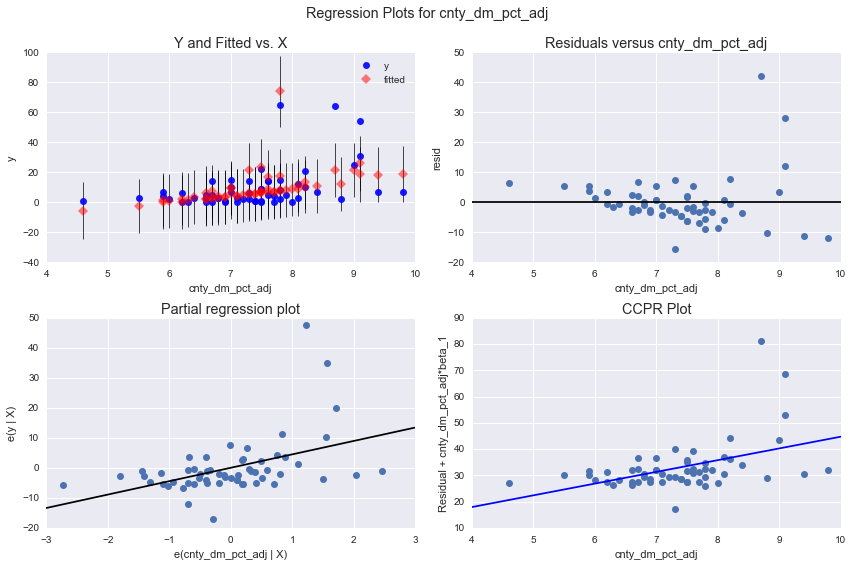

In [38]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(fitted_model, "cnty_dm_pct_adj", fig=fig)

In [142]:
import pymc3 as pm
import scipy
import scipy.stats as stats
import seaborn.apionly as sns
import statsmodels.api as sm
import theano.tensor as tt

from sklearn import preprocessing
x=X
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sd=20)
    x_coeff = pm.Normal('x', 0, sd=20)

    # Define likelihood
    likelihood = pm.Normal('y', mu=intercept + x_coeff * x,
                        sd=sigma, observed=y)

    # Inference!
    start = pm.find_MAP() # Find starting value by optimization
    step = pm.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pm.sample(2000, step, start=start, progressbar=False) # draw 2000 posterior samples using NUTS sampling

Applied log-transform to sigma and added transformed sigma_log to model.


ValueError: Input dimension mis-match. (input[0].shape[1] = 58, input[1].shape[1] = 31)

In [ ]:
plt.figure(figsize=(7, 7))
traceplot(trace[100:])
plt.tight_layout();


### Important Summary Values for Multivariate Regression

* R-squared: When using many predictor variables, this value often becomes inflated. To avoid misinterpretation we must check the ratio between R-squared and the adjusted R-squared values. Gennerally speaking a higher the ratio signifies more redundancies. A ratio that is greater than .20 requires further assessment of the predictors included. 

* standard errors: Larger values signifies more uncertaintity regarding the variable's coefficient estimate. 

* p values: Any variables with a p value < our significance level (0.05), are not likely to be useful in predicting the dependent variable. 

* condition number test: "It signals numeric unstable results when trying an optimization based on matrix inversion. The cause of such instability is due to multicollinearity"(71). "When a condition number is over the score of 30, there's a clear signal that unstable results are rendering the result less reliable. Predictions may be affected by errors and the coef cients may drastically change when rerunning the same regression analysis with a subset or a different set of observations" (71).



### Accounting for Collinearity

######  Deffinitions
* Shared variance: The amount of information that is expressed by another predictor variable.
* Collinearity: Shared variance between two variables  
* Multi-collinearity: Shared variance among three or more variables  
* Partial correlation: The measurement of the association due to unique variance. Signifies a predictor variables contribution in predicting the target variable.

In the previous cells, we assessed each predictor variable's correlation with our target variable using Pearsons Correlation Coefficient. It is important to note however, this approach is only valid when measuring a relationship between two independent variables.
Therefore, if we want to include multiple features in our linear regression model, we must assess our features for collinearity. Meaning we must determine whether "the relation between the variance of the predictor and that of the target is due to unique or shared variance" (Linear Regression, p72).  

This can be done by evaluating the partial correlation of each feature we plan to utilize in our model. This value "represents the exclusive contribution of a variable in predicting the response," and will help us avoid misinterpreting collinear features as significant predictors (Linear Regression, p73).


Both correlation matrices and heatmaps serve as quick methods to check for multi-collinearity amongst our predictors:

In [39]:
correlation_matrix = X.corr()
print (correlation_matrix)

def visualize_correlation_matrix(data, hurdle = 0.0):
    import matplotlib as mpl
    R = np.corrcoef(data, rowvar=0)
    R[np.where(np.abs(R)<hurdle)] = 0.0
    heatmap = plt.pcolor(R, cmap=mpl.cm.coolwarm, alpha=0.8)
    heatmap.axes.set_frame_on(False)
    heatmap.axes.set_yticks(np.arange(R.shape[0]) + 0.5, minor=False)
    heatmap.axes.set_xticks(np.arange(R.shape[1]) + 0.5, minor=False)
    heatmap.axes.set_xticklabels(variables, minor=False)
    plt.xticks(rotation=90)
    heatmap.axes.set_yticklabels(variables, minor=False)
    plt.tick_params(axis='both', which='both', bottom='off', \
    top='off', left = 'off', right = 'off')
    plt.colorbar()
    plt.show()
    

                 cnty_dm_pct_adj  n_tracts
cnty_dm_pct_adj         1.000000  0.172374
n_tracts                0.172374  1.000000


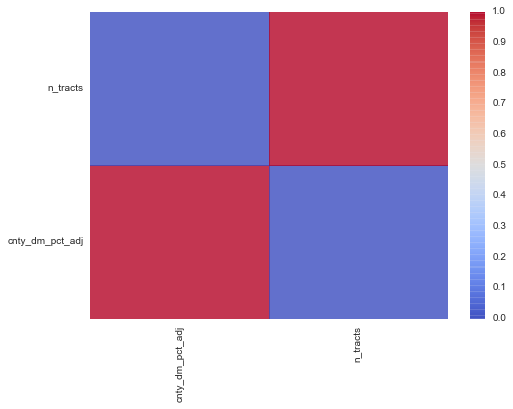

In [40]:
visualize_correlation_matrix(X, hurdle=0.5)#translates into a 25% shared variance

"An even more automatic way to detect such associations (and figure out numerical problems in a matrix inversion) is to use eigenvectors. Explained in layman's terms, eigenvectors are a very smart way to recombine the variance among the variables, creating new features accumulating all the shared variance. Such recombination can be achieved using the NumPy linalg.eig function, resulting in a vector of eigenvalues (representing the amount of recombined variance for each new variable) and eigenvectors (a matrix telling us how the new variables relate to the old ones)" (Regression Analysis, p.74):

In [41]:
corr = np.corrcoef(X, rowvar=0)
eigenvalues, eigenvectors = np.linalg.eig(corr)

After extracting the eigenvalues, we print them in descending order and look for any element whose value is near to zero or small compared to the others. Near zero values can represent a real problem for normal equations and other optimization methods based on matrix inversion. Small values represent a high but not critical source of multicollinearity. 

In [42]:
print (eigenvalues)

[ 1.1724  0.8276]


Using their index position in the list of eigenvalues, you can recall their speci c vector from eigenvectors, which contains all the variable loadings—that is, the
level of association with the original variables. In our example, we investigate the eigenvector at index 5 and 6.

In [43]:

def id_near_zero_eigenvalues(eig_vals):
    mc_sources = []
    for i in range(len(eigenvalues)):
        if eigenvalues[i] <= .1:
            mc_sources += [i]
    return mc_sources

print id_near_zero_eigenvalues(eigenvalues)

[]


In [44]:
def exclude_collinear_vars(eig_vecs, explanatory_vars):
    good_vars = []
    eig_vecs = list(eig_vecs)
    not_collinear = [i for i in range(len(eig_vecs)) if eig_vecs[i] <= 0.1 and eig_vecs[i] >= -0.1]
    for i in not_collinear:
        good_vars += [explanatory_vars[i]]
    return good_vars #var for var in variables if not_collinear

def id_best_feats(eig_vals):
    import itertools, collections
    good_vars = []
    assess_further = id_near_zero_eigenvalues(eigenvalues)
    for i in assess_further:
        good_vars += [exclude_collinear_vars(eigenvectors[:,i], variables)]
    counter = collections.Counter(itertools.chain(*good_vars))
    times_nomc_found = pd.DataFrame([counter.values()], columns=counter.keys()).T
    times_nomc_found.columns = ['count']
    return times_nomc_found#good_vars

num_no_mc_found = id_best_feats(eigenvalues)
num_no_mc_found

,count


In [45]:
from sklearn.preprocessing import StandardScaler
# dataset = df[variables + ['food_deserts']]#perc_effected
# observations = len(dataset)
# variables = dataset.columns
standardization = StandardScaler()
Xst = standardization.fit_transform(X)
original_means = standardization.mean_
originanal_stds = standardization.std_
Xst = np.column_stack((Xst,np.ones(observations)))
# y  = dataset['food_deserts'].values

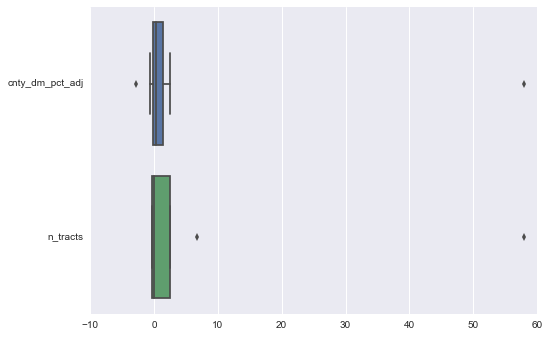

In [46]:
xstd= pd.DataFrame(Xst, columns=variables+['constant']).describe()
#sns.boxplot(Xst[:,:-1])
#boxplot = plt.boxplot(Xst[:,:-1],labels=variables)
ax = sns.boxplot(data=xstd.drop('constant',axis=1), orient="h", whis=1.5)


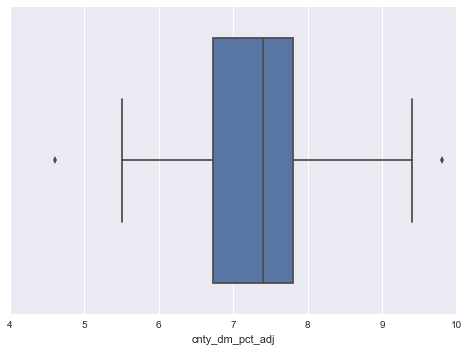

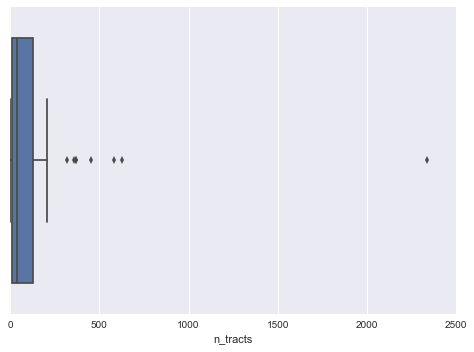

In [47]:
for i in range(len(variables)):
    sns.boxplot(df[variables[i]])
    plt.show()

[ 0.3672  0.311   0.1127  0.0768  0.0532  0.0358  0.0299  0.0132  0.0002]


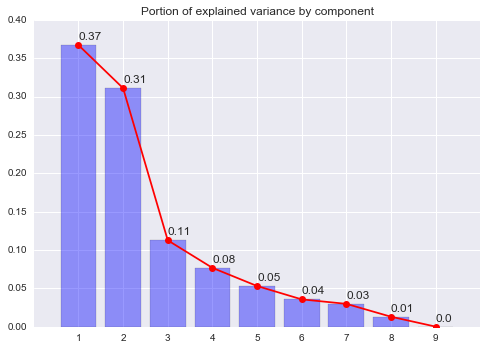

In [140]:
standardization = StandardScaler(with_mean=True, with_std=True)
Xs = standardization.fit_transform(X)

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(Xs)
C = pca.transform(Xs)
print (pca.explained_variance_ratio_)
explained_variance = pca.explained_variance_ratio_
plt.title('Portion of explained variance by component')
range_ = [r+1 for r in range(len(explained_variance))]
plt.bar(range_,explained_variance, color="b", alpha=0.4, align="center")
plt.plot(range_,explained_variance,'ro-')
for pos, pct in enumerate(explained_variance):
    plt.annotate(str(round(pct,2)), (pos+1,pct+0.007))
plt.xticks(range_)
plt.show()


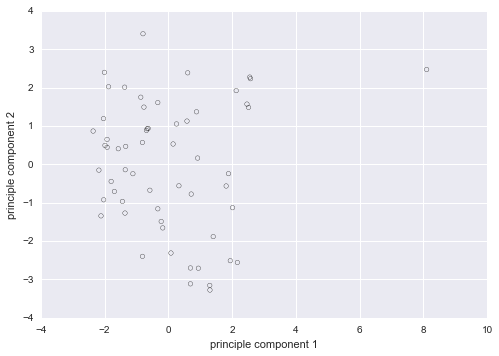

In [142]:
scatter = plt.scatter(C[:,0],C[:,1], facecolors='none', edgecolors='black')
#plt.axhline(y=4, xmin=-6, xmax=6, linewidth=2, color = 'r')
plt.xlabel('principle component 1')
plt.ylabel('principle component 2')

In [143]:
np.where(C[:,0]>6)

(array([18]),)

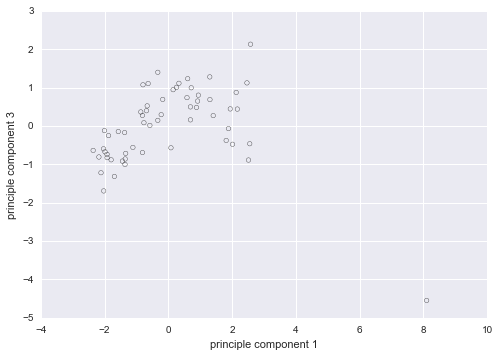

In [144]:
scatter = plt.scatter(C[:,0],C[:,2], facecolors='none', edgecolors='black')
#plt.axhline(y=-2, xmin=-6, xmax=6, linewidth=2, color = 'r')
plt.xlabel('principle component 1')
plt.ylabel('principle component 3')

9.258620689655173

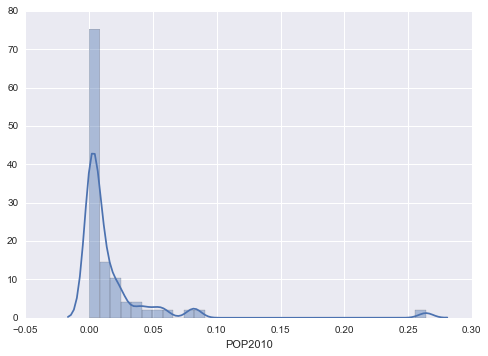

In [146]:
np.where(C[:,2] < -4)
np.shape(X)
sns.distplot(dataset['POP2010'] / dataset['POP2010'].sum())
#sns.distplot(df['food_deserts'] / df['food_deserts'].sum())
df['food_deserts'].mean()
#sns.distplot(df['food_deserts'])

In [147]:
import random

def random_w( p ):
    return np.array([np.random.normal() for j in range(p)])

def hypothesis(X,w):
    return np.dot(X,w)

def loss(X,w,y):
    return hypothesis(X,w) - y

def squared_loss(X,w,y):
    return loss(X,w,y)**2

def gradient(X,w,y):
    gradients = list()
    n = float(len( y ))
    for j in range(len(w)):
        gradients.append(np.sum(loss(X,w,y) * X[:,j]) / n)
    return gradients

def update(X,w,y, alpha=0.01):
    return [t - alpha*g for t, g in zip(w, gradient(X,w,y))]
    
def optimize(X,y, alpha=0.01, eta = 10**-12, iterations = 1000):
    w = random_w(X.shape[1])
    path = list()
    for k in range(iterations):
        SSL = np.sum(squared_loss(X,w,y))
        new_w = update(X,w,y, alpha=alpha)
        new_SSL = np.sum(squared_loss(X,new_w,y))
        w = new_w
        if k>=5 and (new_SSL - SSL <= eta and new_SSL - SSL >= -eta):
            path.append(new_SSL)
            return w, path
        if k % (iterations / 20) == 0:
            path.append(new_SSL)
    return w, path

alpha = 0.02
w, path = optimize(Xst, y, alpha, eta = 10**-12, iterations = 20000)
print ("These are our final standardized coefficients: " + ', '.join(map(lambda x: "%0.4f" % x, w)))


These are our final standardized coefficients: 4.2482, 2.0958, -2.9734, 2.4845, 2.4439, -40.2586, 1.4762, -0.0157, 49.5932, 9.2586


In [148]:
unstandardized_betas = w[:-1] / originanal_stds
unstandardized_bias  = w[-1]-np.sum((original_means / originanal_stds) * w[:-1])
print ('%8s: %8.4f' % ('bias', unstandardized_bias))
for beta,varname in zip(unstandardized_betas, variables):
    print ('%8s: %8.4f' % (varname, beta))

    bias: -67.2762
p_hs_edatt:   0.5663
unemployment_rate:   0.8143
opiods_rx_1000:  -0.0085
cnty_obesity_pct_adj:   0.7034
     ABR:   0.1995
   FFR07:  -0.0389
     std:   0.0079
minority:  -0.0014
 POP2010: 346.6149


In [149]:
cols = dataset.columns.tolist()
y = dataset[cols[-1]].values
#y2 = df['perc_effected'].values
X = df[cols[:-1]]
observations = len(df)
variables = X.columns.tolist()

Xc = sm.add_constant(X)
linear_regression = sm.OLS(y,Xc)
fitted_model = linear_regression.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     25.68
Date:                Sun, 07 Aug 2016   Prob (F-statistic):           1.89e-15
Time:                        00:57:16   Log-Likelihood:                -183.66
No. Observations:                  58   AIC:                             387.3
Df Residuals:                      48   BIC:                             407.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                  -53.1840     25.131     -2.116      0.040      -103.714    -2.654
p_hs_edatt               0.4708      0.240      1.964      0.055        -0.011     0.953
unemployment_rate        0.6643      0.540      1.231      0.224        -0.421     1.749
opiods_rx_1000          -0.0053      0.004     -1.203      0.235        -0.014     0.004
cnty_obesity_pct_adj     0.3730      0.365      1.021      0.313        -0.362     1.108
ABR                      0.1516      0.104      1.453      0.153        -0.058     0.361
FFR07                   -0.0710      0.012     -5.748      0.000        -0.096    -0.046
std                      0.0088      0.007      1.349      0.184        -0.004     0.022
minority                 0.0221      0.118      0.188      0.852        -0.215     0.259
POP2010                578.3946     89.244      6.481      0.000       398.957   757.832
==============================================================================
Omnibus:                       55.805   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              385.946
Skew:                           2.498   Prob(JB):                     1.56e-84
Kurtosis:                      14.608   Cond. No.                     1.33e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [150]:
X.head()

,p_hs_edatt,unemployment_rate,opiods_rx_1000,cnty_obesity_pct_adj,ABR,FFR07,std,minority,POP2010
County,,,,,,,,,
Alameda,85.700000,8.208532,557.20,20.4,18.09375,1112.0,607.109,48.341250,0.153716
Alpine,81.668627,11.669231,578.68,23.2,0.00000,2.0,0.000,31.040000,0.000000
Amador,87.700000,11.056250,1244.76,22.8,19.00000,18.0,198.082,5.553333,0.003760
Butte,86.100000,11.229358,1389.20,24.3,23.88750,149.0,394.598,9.656250,0.022289
Calaveras,93.100000,8.125000,1068.98,25.3,17.70000,27.0,120.997,6.080000,0.004523


### Standardized Coefficients

In [151]:
def unstandardized_coeffs(X,predictor_names,y):
    res = {}
    not_std_model = linear_model.LinearRegression(normalize=False,fit_intercept=True)
    not_std_model.fit(X,y)
    for coef, var in sorted(zip(map(abs,not_std_model.coef_), predictor_names), reverse=True):
        print ("%6.3f %s" % (coef,var))
        res[var] = coef
    return res

def standardized_coeffs(X,predictor_names,y):
    res={}
    from sklearn.pipeline import make_pipeline
    standardization = StandardScaler()
    reg_model = linear_model.LinearRegression(normalize=False,fit_intercept=True)
    Std_model = make_pipeline(standardization,reg_model)
    Std_model.fit(X,y)
    for coef, var in sorted(zip(map(abs,Std_model.steps[1][1].coef_), predictor_names), reverse=True):
        print ("%6.3f %s" % (coef,var))
        res[var] = coef
    return res

nonstd_coeffs = unstandardized_coeffs(X=X,predictor_names=dataset.columns[:-1],y=y)

std_coeffs = standardized_coeffs(X=X,predictor_names=dataset.columns[:-1],y=y)

# linear_regression = linear_model.LinearRegression(normalize=False,fit_intercept=True)
# from sklearn.pipeline import make_pipeline
# standardization = StandardScaler()
# Stand_coef_linear_reg = make_pipeline(standardization,linear_regression)
# linear_regression.fit(X,y)
# for coef, var in sorted(zip(map(abs,linear_regression.coef_), dataset.columns[:-1]), reverse=True):
#     print ("%6.3f %s" % (coef,var))

578.395 POP2010
 0.664 unemployment_rate
 0.471 p_hs_edatt
 0.373 cnty_obesity_pct_adj
 0.152 ABR
 0.071 FFR07
 0.022 minority
 0.009 std
 0.005 opiods_rx_1000
82.756 POP2010
73.441 FFR07
 3.532 p_hs_edatt
 1.857 ABR
 1.854 opiods_rx_1000
 1.710 unemployment_rate
 1.635 std
 1.317 cnty_obesity_pct_adj
 0.251 minority


In [152]:
#pd.DataFrame(std_coeffs)
coeffs = pd.DataFrame.from_dict([std_coeffs, nonstd_coeffs]).T
coeffs.columns=['standardized','non_standardized']
coeffs

,standardized,non_standardized
ABR,1.857002,0.151567
FFR07,73.441441,0.071000
POP2010,82.755907,578.394552
cnty_obesity_pct_adj,1.317484,0.372979
minority,0.251066,0.022118
opiods_rx_1000,1.854442,0.005325
p_hs_edatt,3.531775,0.470783
std,1.635193,0.008796
unemployment_rate,1.709637,0.664275


## Partial R squared

In [153]:
from sklearn.metrics import r2_score
linear_regression = linear_model.LinearRegression(normalize=False,fit_intercept=True)
def r2_est(X,y):
    return r2_score(y,linear_regression.fit(X,y).predict(X))

print ('Baseline R2: %0.3f' %  r2_est(X,y))
r2_impact = list()
for j in range(X.shape[1]):
    selection = [i for i in range(X.shape[1]) if i!=j]
    r2_impact.append(((r2_est(X,y) - r2_est(X.values [:,selection],y)) ,dataset.columns[j]))
for imp, varname in sorted(r2_impact, reverse=True):
    print ('%6.3f %s' %  (imp, varname))

Baseline R2: 0.828
 0.150 POP2010
 0.118 FFR07
 0.014 p_hs_edatt
 0.008 ABR
 0.007 std
 0.005 unemployment_rate
 0.005 opiods_rx_1000
 0.004 cnty_obesity_pct_adj
 0.000 minority


## Assessing Interactions

In [154]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
linear_regression = linear_model.LinearRegression(normalize=False,fit_intercept=True)
create_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

def r2_est(X,y):
          return r2_score(y,linear_regression.fit(X,y).predict(X))
baseline = r2_est(X,y)
print ('Baseline R2: %0.3f' % baseline)
Xi = create_interactions.fit_transform(X)
main_effects = create_interactions.n_input_features_
for k,effect in enumerate(create_interactions.powers_[(main_effects):]):
    #print effect
    idx= [i for i in range(len(effect)) if effect[i]==1]
    #print 
    termA, termB =  variables[idx[0]],variables[idx[1]]
    #termA, termB = variables[effect==1]
    increment = r2_est(Xi[:,list(range(0,main_effects)) +[main_effects+k]],y) - baseline
    if increment > 0.01:
        print ('Adding interaction %8s *%8s R2: %5.3f' %  (termA, termB, increment))


Baseline R2: 0.828
Adding interaction unemployment_rate *   FFR07 R2: 0.037
Adding interaction unemployment_rate * POP2010 R2: 0.054
Adding interaction opiods_rx_1000 *   FFR07 R2: 0.038
Adding interaction opiods_rx_1000 * POP2010 R2: 0.033
Adding interaction cnty_obesity_pct_adj *   FFR07 R2: 0.073
Adding interaction cnty_obesity_pct_adj * POP2010 R2: 0.087
Adding interaction      ABR *   FFR07 R2: 0.051
Adding interaction      ABR * POP2010 R2: 0.063
Adding interaction    FFR07 *     std R2: 0.010
Adding interaction    FFR07 *minority R2: 0.033
Adding interaction    FFR07 * POP2010 R2: 0.042
Adding interaction      std * POP2010 R2: 0.011
Adding interaction minority * POP2010 R2: 0.035


In [155]:
Xi = X
Xi['interaction'] = X['cnty_obesity_pct_adj']*X['POP2010']
print ('R2 of a model with cnty_obesity_pct_adj*POP2010 interaction: %0.3f' % r2_est(Xi,y))


R2 of a model with cnty_obesity_pct_adj*POP2010 interaction: 0.915


/Users/desert/anaconda/envs/linreg/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [156]:
residuals = y - linear_regression.predict(X)
print ("Head of residual %s" % residuals[:5])
print ("Mean of residuals: %0.3f" % np.mean(residuals))
print ("Standard deviation of residuals: %0.3f" % np.std(residuals))

Head of residual [ 2.5856  0.345  -2.1147  8.8446  0.9684]
Mean of residuals: -0.000
Standard deviation of residuals: 4.030


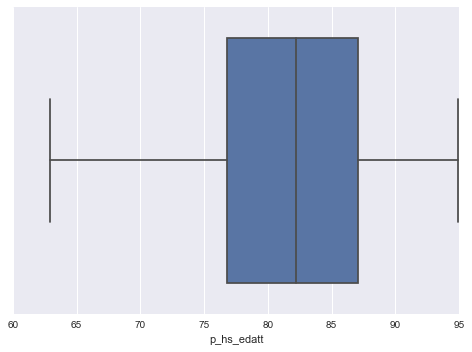

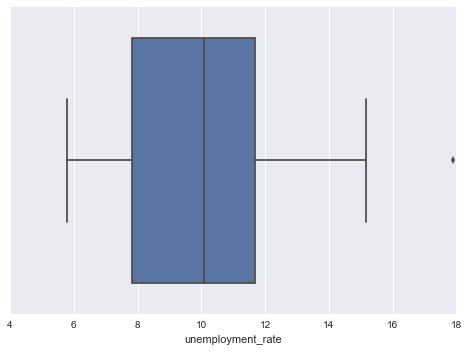

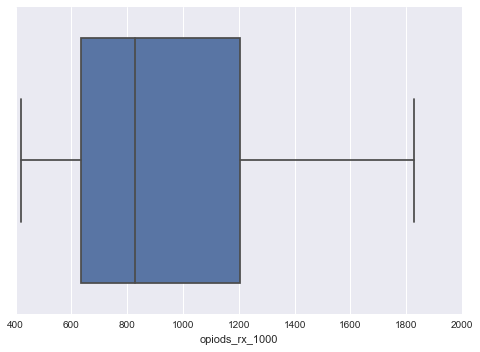

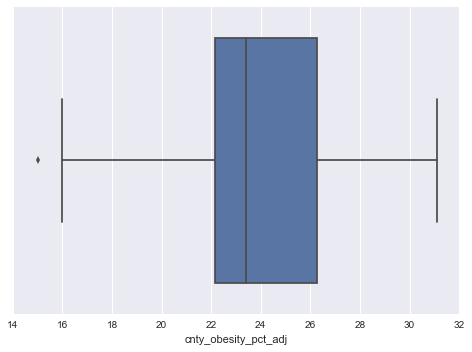

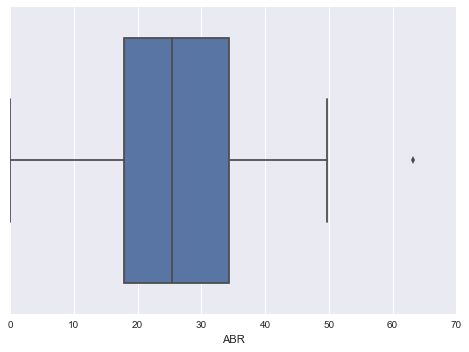

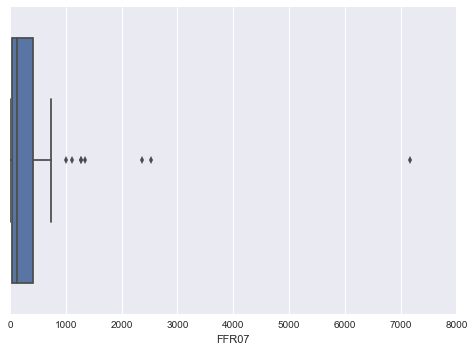

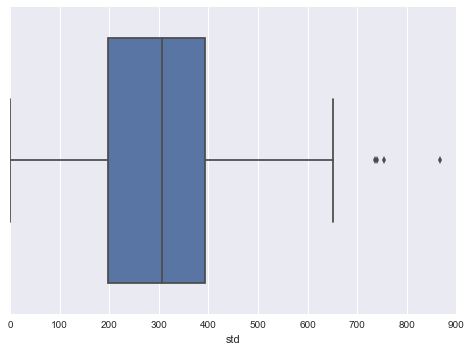

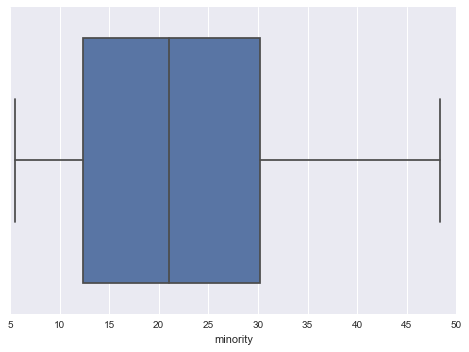

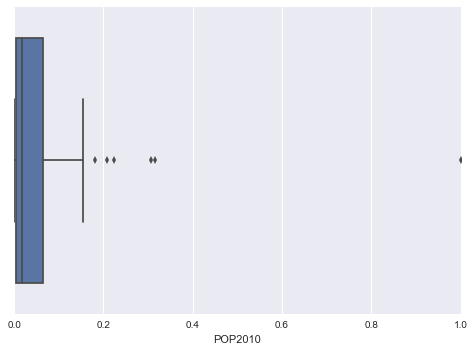

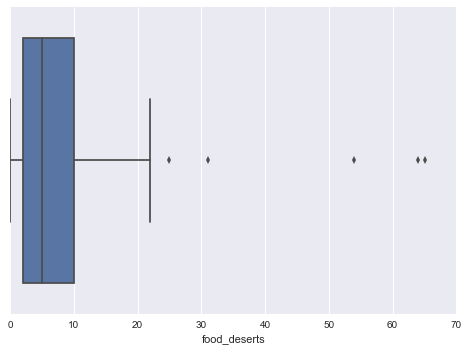

In [158]:
for c in variables+['food_deserts']:
    sns.boxplot(x=df[c])
    #plt.boxplot(dataset[c])#, labels=c)
    plt.show()
#plt.boxplot(y,labels=('perc_effected'))

In [ ]:
variables#2,5,7
var=-1

def map_bin(x, bins):
    kwargs = {}
    if x == max(bins):
        kwargs['right'] = True
    bin = bins[np.digitize([x], bins, **kwargs)[0]]
    bin_lower = bins[np.digitize([x], bins, **kwargs)[0]-1]
    return '[{0}-{1}]'.format(bin_lower, bin)
#map_bin(274, freq_bins)


def binning(col, cut_points, labels=None):
    #Define min and max values:
    minval = col.min()
    maxval = col.max()

    #create list by adding min and max to cut_points
    #break_points = [minval] + cut_points + [maxval]
    break_points=cut_points

    #if no labels provided, use default labels 0 ... (n-1)
    if not labels:
        labels = range(len(cut_points)+1)
    #Binning using cut function of pandas
    colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
    return colBin

#Binning age:
cut_points = [.25,.5,.75]
#binning(X["POP2010"], cut_points)
bins = [0, 25, 50, 75, 100]
group_names = ['Low', 'Okay', 'Good', 'Great']

group_names = ['0','25','50','75']
#categories = pd.cut(df['postTestScore'], bins, labels=group_names)
pd.cut(X["POP2010"], bins, labels=group_names)
#pd.qcut(X["POP2010"], 10)#.value_counts()
#pd.cut(X["POP2010"],bins=[.25,.5,.75,1.0])#,labels=cut_points,include_lowest=True)
#print pd.value_counts(data["LoanAmount_Bin"], sort=False)
# from sklearn.preprocessing import LabelBinarizer
# LB = LabelBinarizer()
# X_t = X.drop('interaction',axis=1).copy()
# #variab
# edges = np.histogram(X_t[variables[var]], bins=5)[1]
# binning = np.digitize(X_t[variables[var]], edges)
# # X_t = np.column_stack((np.delete(X_t, var, axis=1),LB.fit_transform(binning)))
# # linear_regression.fit(X_t, y)
# # print ("R-squared: %0.3f" % r2_score(y, linear_regression.predict(X_t)))
# variables[-1]
# np.histogram(X_t[variables[var]], bins=10)

The residuals of a linear regression always have mean zero and their standard deviation depends on the size of the error produced. Residuals can provide insight on an unusual observation and non-linearity because, after telling us about what's left, they can direct us to speci c troublesome data points or puzzling patterns in data.
For the speci c problem of detecting non-linearity, we are going to use a plot based on residuals called the partial residual plot. In this plot, we compare the regression residuals summed with the values derived from the modeled coef cient of a variable against the original values of the variable itself: 148

In [ ]:
var = -1 # the variable in position 8 is std
partial_residual = residuals + X[variables[var]].values * linear_regression.coef_[var]
plt.plot(X[variables[var]].values, partial_residual, 'wo')
plt.xlabel(variables[var])
plt.ylabel('partial residuals')
plt.show()

In [ ]:
linear_regression.coef_

In [ ]:
sns.pairplot(dataset)

In [ ]:
def lin_regplot(X_feat, y, model):
    X = np.array(df[X_feat]).reshape(-1, 1)
    model.fit(X,y)
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red')
    return None

def lr_with_bias(X_feat, y):
    x = np.array(df[X_feat])
    x = np.array([[v,1] for v in x]) 
    (slope,bias),total_error,_,_ = np.linalg.lstsq(x,y)
    rmse = np.sqrt(total_error[0]/len(x))
    print rmse
    plt.plot(x[:,0], slope*x[:,0], c='red')
    plt.scatter(x[:,0], y, c='blue')
    #plt.plot(slope,bias,color='red')
    return None


lr_with_bias('POP2010',y)#,linear_regression)
plt.show()
lin_regplot('POP2010',y,linear_regression)
# x = boston.data[:,5]
# x = np.array([[v,1] for v in x]) # we now use [v,1] instead of [v]
# y = boston.target


In [ ]:
target = 'food_deserts'
target2 = ['perc_effected']
predictors = [c for c in X.columns if c in df.columns]
#predictors = [c for c in X.columns if c != '30 _readmits']

#form = "{} ~ {} + 1".format(target, ' + '.join(predictors))
form
#model = smf.ols(formula=form, data=df).fit()
#model.summary()
#df['30_readmits']
df[predictors].info(verbose=True)

In [ ]:
sns.pairplot(data)

In [ ]:
sns.distplot(df['des_percent'])

In [ ]:
sns.distplot(df['food_deserts'])

In [ ]:
sns.distplot(df['perc_effected'])

In [ ]:
sns.distplot(df['pop_effected'])

In [ ]:
#access = ['PC_PHYS_R','DENTIST_R','PSYCH_R', 'n_hospitals']

lr = smf.ols(formula='food_deserts ~ PC_PHYS_R+DENTIST_R+PSYCH_R+n_hospitals', data=df).fit()
#lr = smf.ols(formula='n_hospitals ~ food_deserts', data=df).fit()
lrr = smf.rlm(formula='food_deserts ~ PC_PHYS_R+DENTIST_R+PSYCH_R+n_hospitals', data=df).fit()

print lrr.summary()
y= df['food_deserts'].values
X = df[['PC_PHYS_R','DENTIST_R','PSYCH_R','n_hospitals']].values
norm_x = np.ones_like(X)
for i in range(int(lr.df_model)):
    norm_x[:,i] = X[:,i]/np.linalg.norm(X[:,i])
norm_xtx = np.dot(norm_x.T,norm_x)

In [ ]:
norm_xtx
eigs = np.linalg.eigvals(norm_xtx)
condition_number = np.sqrt(eigs.max() / eigs.min())
print condition_number

In [ ]:
ols_results2 = sm.OLS(y[:-1], X[:-1,:]).fit()
print "Percentage change %4.2f%% \n"*4 % tuple([i for i in lr.params/ols_results2.params*100 - 100])
#[i for i in lr.params/ols_results2.params*100 - 100]

In [ ]:
#data['n_hospitals_c'] = (data['n_hospitals'] - data['n_hospitals'].mean())
#gapmind1['urbanrate_c'] = (gapmind1['urbanrate'] - gapmind1['urbanrate'].mean())
#data.describe()
# corr=np.corrcoef(X, rowvar=0)  # correlation matrix
# w, v = np.linalg.eig(corr)        # eige
# w
corr = np.corrcoef(X, rowvar=0)
eigenvalues, eigenvectors = np.linalg.eig(corr)
print eigenvalues

In [ ]:
def visualize_correlation_matrix(data, hurdle = 0.0):
    import matplotlib as mpl
    variables = data.columns.tolist()
    R = np.corrcoef(data, rowvar=0)
    R[np.where(np.abs(R)<hurdle)] = 0.0
    heatmap = plt.pcolor(R, cmap=mpl.cm.coolwarm, alpha=0.8)
    heatmap.axes.set_frame_on(False)
    heatmap.axes.set_yticks(np.arange(R.shape[0]) + 0.5, minor=False)
    heatmap.axes.set_xticks(np.arange(R.shape[1]) + 0.5, minor=False)
    heatmap.axes.set_xticklabels(variables, minor=False)
    plt.xticks(rotation=90)
    heatmap.axes.set_yticklabels(variables, minor=False)
    plt.tick_params(axis='both', which='both', bottom='off', \
    top='off', left = 'off', right = 'off')
    plt.colorbar()
    plt.show()

visualize_correlation_matrix(X, hurdle=0.5)

X = df[['PC_PHYS_R','DENTIST_R','PSYCH_R','n_hospitals']]
visualize_correlation_matrix(X, hurdle=0.5)


In [ ]:
def id_near_zero_eigenvalues(eig_vals):
    mc_sources = []
    for i in range(len(eigenvalues)):
        if eigenvalues[i] <= .1:
            mc_sources += [i]
    return mc_sources

corr = np.corrcoef(X, rowvar=0)
eigenvalues, eigenvectors = np.linalg.eig(corr)
print eigenvalues
possible_multicollinear_evals = id_near_zero_eigenvalues(eigenvalues)

variables = X.columns.tolist()

In [ ]:
possible_multicollinear_evals

In [ ]:
def get_VIF(variables):
    vifs = {}
    for i in range(len(variables)):
        target = variables[i]
        preds = [c for c in variables if c != target]
        form = "{} ~ {} + 1".format(target,
                                   ' + '.join(preds))  
        model = smf.ols(formula=form, data=df).fit()
        r2 = model.rsquared
        
        vif = 1/(1-r2)
        vifs[target] = vif
    return vifs



get_VIF(['PC_PHYS_R','DENTIST_R','PSYCH_R','n_hospitals'])
get_VIF(['PC_PHYS_R','DENTIST_R','n_hospitals'])
get_VIF(['PC_PHYS_R','n_hospitals'])
get_VIF(['des_percent','food_deserts'])

In [ ]:
# #sns.jointplot(x='food_deserts', y='n_hospitals', data=df, kind='reg')
# pred=lr.predict(pd.DataFrame(df['food_deserts']))
# pred
# df.plot(kind='scatter', x='food_deserts', y='n_hospitals')
# plt.plot(pd.DataFrame(df['food_deserts']),pred,c='red',linewidth=2)




In [ ]:
def is_outlier(value, p25, p75):
    """Check if value is an outlier
    """
    lower = p25 - 1.5 * (p75 - p25)
    upper = p75 + 1.5 * (p75 - p25)
    return value <= lower or value >= upper
 

def get_indices_of_outliers(values):
    """Get outlier indices (if any)
    """
    p25 = np.percentile(values, 25)
    p75 = np.percentile(values, 75)
     
    indices_of_outliers = []
    for ind, value in enumerate(values):
        if is_outlier(value, p25, p75):
            indices_of_outliers.append(ind)
    return indices_of_outliers
 

X1 = df[['n_hospitals','food_deserts']]
X2 = df['food_deserts']

feat=X1.iloc[:,1]
feat2=X1.iloc[:,0]

values=X1.iloc[:,1].values
y=X1.iloc[:,1].values
indices_of_outliers = get_indices_of_outliers(feat)
 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(feat, 'b-', label='n_hospitals')
ax.plot(indices_of_outliers, values[indices_of_outliers],'ro',markersize = 7,label='outliers')
ax.legend(loc='best')

In [ ]:
# df['n_hospitals'].max
feat.max()
#df.iloc[1134, 'n_hospitals']
X1

#plt.plot(X1.iloc[:,1], 'b-')#, label=x1cols[0])
plt.scatter(X1.iloc[:,0].values, X1.iloc[:,1].values)
plt.plot( values[indices_of_outliers],y[indices_of_outliers],'ro',markersize = 7,label='outliers')